This numerical calculation is refered to "Propagation constant-based diameter measurement technique for a submicrometer-scale optical fiber."https://doi.org/10.1364/OL.521545


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv, kv, jvp, kvp
from scipy.optimize import root_scalar

In [14]:
#Sellmeir-type dispertions
def refractive_index_fused_silica(lamda):
    return np.sqrt(1 + ((0.6961663 * lamda**2)/((lamda**2)-(0.0684043)**2)) \
                   + ((0.4079426 * lamda**2) / ((lamda**2) - (0.1162414)**2))\
                      + ((0.8974794 * lamda**2)/(lamda**2 - (9.896161)**2)))

In [16]:
print(refractive_index_fused_silica(1.55021))

1.4440211052865322


In [18]:
# Function to calculate diameter by solving eigen equation
def calculate_diameter(pitch, n_air, n_fiber, wavelength):
    k0 = 2 * np.pi / wavelength  # Wavenumber in vacuum
    beta = np.pi / pitch

    def eigenvalue_eq(diameter):
        if beta > k0 * n_fiber or beta < k0 * n_air:
            return np.inf
        
        u = (diameter / 2) * np.sqrt(k0**2 * n_fiber**2 - beta**2)
        w = (diameter / 2) * np.sqrt(beta**2 - k0**2 * n_air**2)
        
        if u <= 0 or w <= 0:
            return np.inf
        
        lhs = ((1/u**2) + (1/w**2)) * ((1/u**2)+((n_air**2 / n_fiber**2) * (1/w**2)))
        rhs = (((1 / u) * (jvp(1, u) / jv(1, u))) + ((1 / w) * (kvp(1, w) / kv(1, w)))) * \
              (((1 / u) * (jvp(1, u) / jv(1, u))) + ((n_air**2 / n_fiber**2) * (1 / w) * (kvp(1, w) / kv(1, w))))
        return lhs - rhs
    
    diameter_min = 0.005
    diameter_max = 1.30
    
    if eigenvalue_eq(diameter_min) * eigenvalue_eq(diameter_max) > 0:
        return np.nan
    
    try:
        sol = root_scalar(eigenvalue_eq, bracket=[diameter_min, diameter_max], method='brentq', xtol=1e-6)
        return sol.root if sol.converged else np.nan
    except ValueError:
        return np.nan

In [19]:
calculate_diameter(pitch=0.764, n_air=1, n_fiber=1.4440211052865322, wavelength=1.55021) # um, 1, um 
# um

0.55953534725935

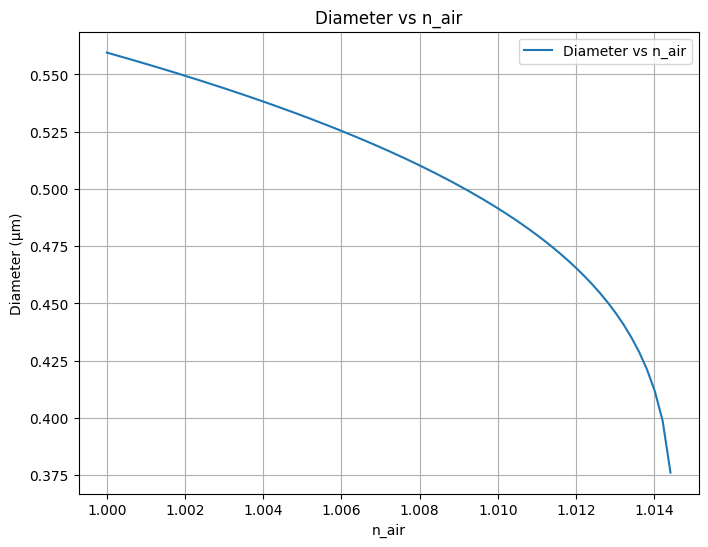

In [36]:
# Sweep n_air from 1 to 1.2
n_air_values = np.linspace(1, 1.2, 1000)
diameters_for_n_air = [calculate_diameter(pitch=0.764, n_air=n_air, n_fiber=1.4440211052865322, wavelength=1.55021) for n_air in n_air_values]

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(n_air_values, diameters_for_n_air, label='Diameter vs n_air')
plt.xlabel('n_air')
plt.ylabel('Diameter (µm)')
plt.title('Diameter vs n_air')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
n1 = 1.4440211052865322

In [24]:
def n_air_eff(l, d):
    return 1 + np.exp(-l/d) * (n1 - 1)

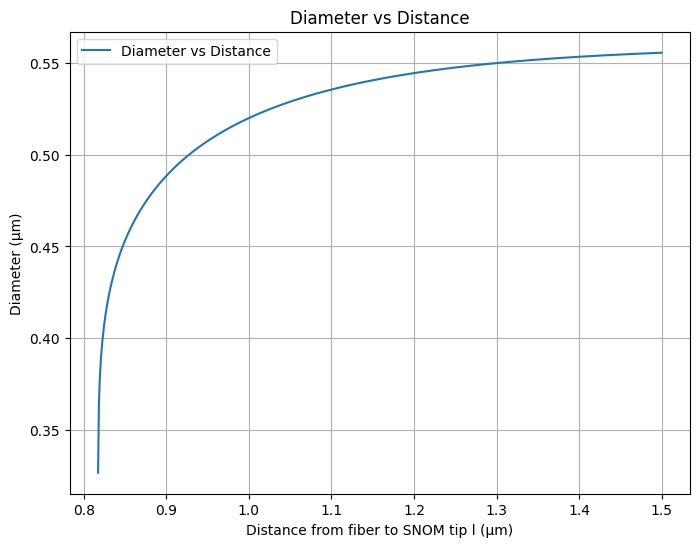

In [35]:
# Sweep l from 500e-9 to 1500e-9
l_values = np.linspace(500e-9, 1500e-9, 1000)
diameters_for_n_air_eff = [calculate_diameter(pitch=0.764, n_air=n_air_eff(l=l, d=239e-9), n_fiber=n1, wavelength=1.55021) for l in l_values]

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(l_values*1e6, diameters_for_n_air_eff, label='Diameter vs Distance')
plt.xlabel('Distance from fiber to SNOM tip l (μm)')
plt.ylabel('Diameter (µm)')
plt.title('Diameter vs Distance')
plt.grid(True)
plt.legend()
plt.show()

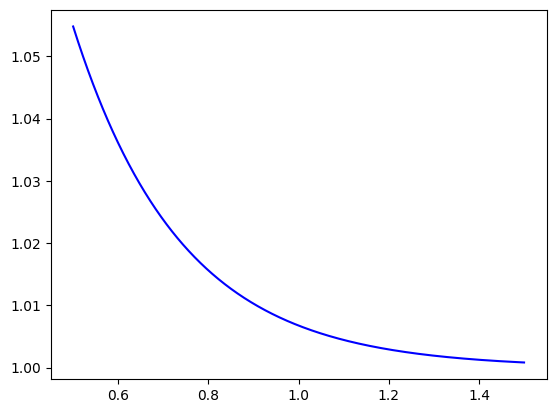

In [33]:
n_air_values = [n_air_eff(l=l, d=239e-9) for l in l_values]
plt.plot(l_values*1e6, n_air_values, label='n_air_eff vs Distance', color='b')